# Hierarchical Clustering of Lung Cancer Coabundance Networks

In [62]:
import numpy as np
from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

plt.switch_backend("cairo")

import graph_tool.all as gt


In [138]:
# ! pacman -S python-pip
! pacman -S --noconfirm python-networkx

resolving dependencies...
looking for conflicting packages...

Package (1)            New Version  Net Change  Download Size

extra/python-networkx  3.3-2         22.61 MiB       3.16 MiB

Total Download Size:    3.16 MiB
Total Installed Size:  22.61 MiB

:: Proceed with installation? [Y/n] 
:: Retrieving packages...
 python-networkx-3.3-2-any downloading...
checking keyring...
checking package integrity...
loading package files...
checking for file conflicts...
:: Processing package changes...
installing python-networkx...
Optional dependencies for python-networkx
    python-lxml: for GraphML XML format
    python-pydot: for graph drawing and graph layout algorithms in pure Python
    via GraphViz
    python-pygraphviz: for graph drawing and graph layout algorithms with
    bindings to GraphViz
    python-sympy: for polynomial algorithms
:: Running post-transaction hooks...
(1/1) Arming ConditionNeedsUpdate...


In [139]:
import networkx as nx

In [156]:
net_folder = '/root/host_home/luca/outputARACNE/'

# Define colors for different cell categories
color_map = {
    'immune adaptive': 'lightgreen',
    'immune native': 'lightblue',
    'immune both': 'purple',
    'stromal': '#D2B48C',
    'epithelial': 'orange',
    'tumoral': 'red'
}

# Define cell categories
cell_categories = {
    'immune adaptive': ['T cell CD8 activated', 'T cell CD4', 'B cell', 'B cell dividing', 'T cell regulatory', 'T cell CD8 effector memory',
                         'T cell CD8 activated', 'cDC2', 'T cell CD8 terminally exhausted', 'T cell CD4 dividing', 'T cell CD8 dividing', 'T cell CD8 naive'],
    'immune both': ['Mast cell', 'myeloid dividing', 'pDC', 'DC mature', 'T cell NK-like', "Plasma cell", "Plasma cell dividing"],
    'immune native': ['Monocyte classical', 'Monocyte non-classical', 'NK cell', 'Macrophage', 'Macrophage alveolar', 'NK cell dividing', 'Neutrophils', 'cDC1'],
    'stromal': ['Fibroblast peribronchial', 'Fibroblast alveolar', 'Endothelial cell venous', 'Endothelial cell lymphatic',
                 'Endothelial cell capillary', 'Smooth muscle cell', 'Pericyte', 'Fibroblast adventitial', 'stromal dividing'],
    'epithelial': ['Alveolar cell type 1', 'Alveolar cell type 2', 'Ciliated', 'Club', 'transitional club/AT2', 'ROS1+ healthy epithelial'],
    'tumoral': ['Tumor cells LUAD', 'Tumor LUAD_mixed', 'Tumor LUAD_transitional', 'Tumor LUAD_LUSC', 'Tumor LUAD_mitotic', 'Tumor LUAD_LUSC_mitotic', 'Tumor LUAD_mainly1']
}

cell_type_to_category = {}
for category, cell_types in cell_categories.items():
    for cell_type in cell_types:
        cell_type_to_category[cell_type] = category


# Define function to get state from file
def get_state_from_file(time, net_folder=net_folder):
  time_solo = time.split('_')[0]

  file_path = f'{net_folder}/net{time}.txt'

  g = gt.load_graph_from_csv(file_path, csv_options={"delimiter":'\t'}, eprop_types=[   "float", "float"], eprop_names=['MI', 'pvals'])

  # Remove repeated edges VERY STRANGE WITH REPEATED EDGES THERE IS MORE STRUCTURE, THAT MAY ALSO BE BECAUSE SOME EDGES ARE NOT REPEATED AND SOME ARE
  edges = list(g.edges())
  edge_set = set()
  for edge in edges:
      if (edge.source(), edge.target()) in edge_set or (edge.target(), edge.source()) in edge_set:
          g.remove_edge(edge)
      else:
          edge_set.add((edge.source(), edge.target()))

  print(g)
  state = gt.minimize_nested_blockmodel_dl(g)

  entropy_1 = state.entropy()

  entropy_2 = gt.mcmc_anneal(state, beta_range=(1, 20), niter=1500,
                             mcmc_equilibrate_args=dict(force_niter=20))

  print("Without annealing: " + str(entropy_1))
  print("With annealing: " + str(entropy_2) )

  return state, g


def paint_net_from_state(state, g, time, mi_divisor=16):

    # Assign cell category and color
    g.vp.cat = g.new_vertex_property("string")
    g.vp.color = g.new_vertex_property("string")
    for v in g.vertices():
        g.vp.cat[v] = cell_type_to_category[g.vp.name[v]]
        g.vp.color[v] = color_map[g.vp.cat[v]]

    e_width = g.new_edge_property("float")
    e_width.a = g.ep.MI.a/mi_divisor

    e_gradient = g.new_edge_property("vector<float>")
    for e in g.edges():
        v = e.source()
        rgb = list(mcolors.to_rgba(g.vp.color[v]))
        e_gradient[e] = [   0, rgb[0], rgb[1], rgb[2], 0.7,
                            1, rgb[0], rgb[1], rgb[2], 0.1
                        ]

    fig, ax = plt.subplots(figsize=(12, 10))
    a = state.draw(vertex_fill_color=g.vp.color,
                edge_pen_width=e_width,
                #  vertex_halo_color=g.vp.color,
                vertex_text=g.vp.name,
                vertex_text_size=8,
                vertex_text_position='centered',
                edge_gradient = e_gradient,
                vertex_pen_width=0.0,
                # vertex_size=gt.prop_to_size(g.degree_property_map("total"), mi=0.01, ma=0.02, power=1),
                mplfig=ax,
    )
    a[0].fit_view(yflip=True)
    ax.set_title(time)
    ax.set_axis_off()

    # Add legend to the plot
    handles = []
    for category, color in color_map.items():
        handles.append(mpatches.Patch(color=color, label=category))
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 0.5), loc='upper left')
    plt.subplots_adjust(right=0.8)  # Adjust right margin for the legend


    fig.savefig(f"{net_folder}/graph_{time}.png")
    plt.close(fig)

    return Image(filename=f"{net_folder}/graph_{time}.png")

## Get state

In [157]:
state_late, g_late = get_state_from_file("III-IV_leiden")

<Graph object, undirected, with 40 vertices and 162 edges, 1 internal vertex property, 2 internal edge properties, at 0x7ff3d28a1790>
Without annealing: 412.2986785789717
With annealing: (412.2986785789717, 6333766, 38040)


In [ ]:
state_early, g_early = get_state_from_file("I-II_leiden")

state_late, g_late = get_state_from_file("III-IV_leiden")

# Takes 2m12 in docker container

<Graph object, undirected, with 47 vertices and 193 edges, 1 internal vertex property, 2 internal edge properties, at 0x7ff3d3b2b1a0>
Without annealing: 511.2308920967499
With annealing: (511.2308920967499, 31168850, 209170)
<Graph object, undirected, with 40 vertices and 162 edges, 1 internal vertex property, 2 internal edge properties, at 0x7ff3d8f28d10>
Without annealing: 412.2986785789717
With annealing: (412.2986785789717, 6464402, 35469)


We used to have repeted edges and this gave us mch more structure. We need to analyze why if this is valid, and why ARACNE does that.

In [ ]:
state_early, g_early = get_state_from_file("I-II_leiden")

state_late, g_late = get_state_from_file("III-IV_leiden")

<Graph object, undirected, with 47 vertices and 370 edges, 3 internal vertex properties, 2 internal edge properties, at 0x7b3a47b09810>


/usr/local/lib/python3.10/dist-packages/graph_tool/inference/blockmodel.py:389: UserWarning: unrecognized keyword arguments: ['seed']
  warnings.warn("unrecognized keyword arguments: " +


Without annealing: 783.2957770484696
With annealing: (772.186992519002, 3185231, 1094944)
<Graph object, undirected, with 40 vertices and 314 edges, 3 internal vertex properties, 2 internal edge properties, at 0x7b3a412c23b0>
Without annealing: 637.1048499292
With annealing: (630.614762721955, 2610297, 1000624)


## Paint networks

<EdgePropertyMap object with value type 'vector<double>', for Graph 0x7ff3d3b2b1a0, at 0x7ff407f34d10>


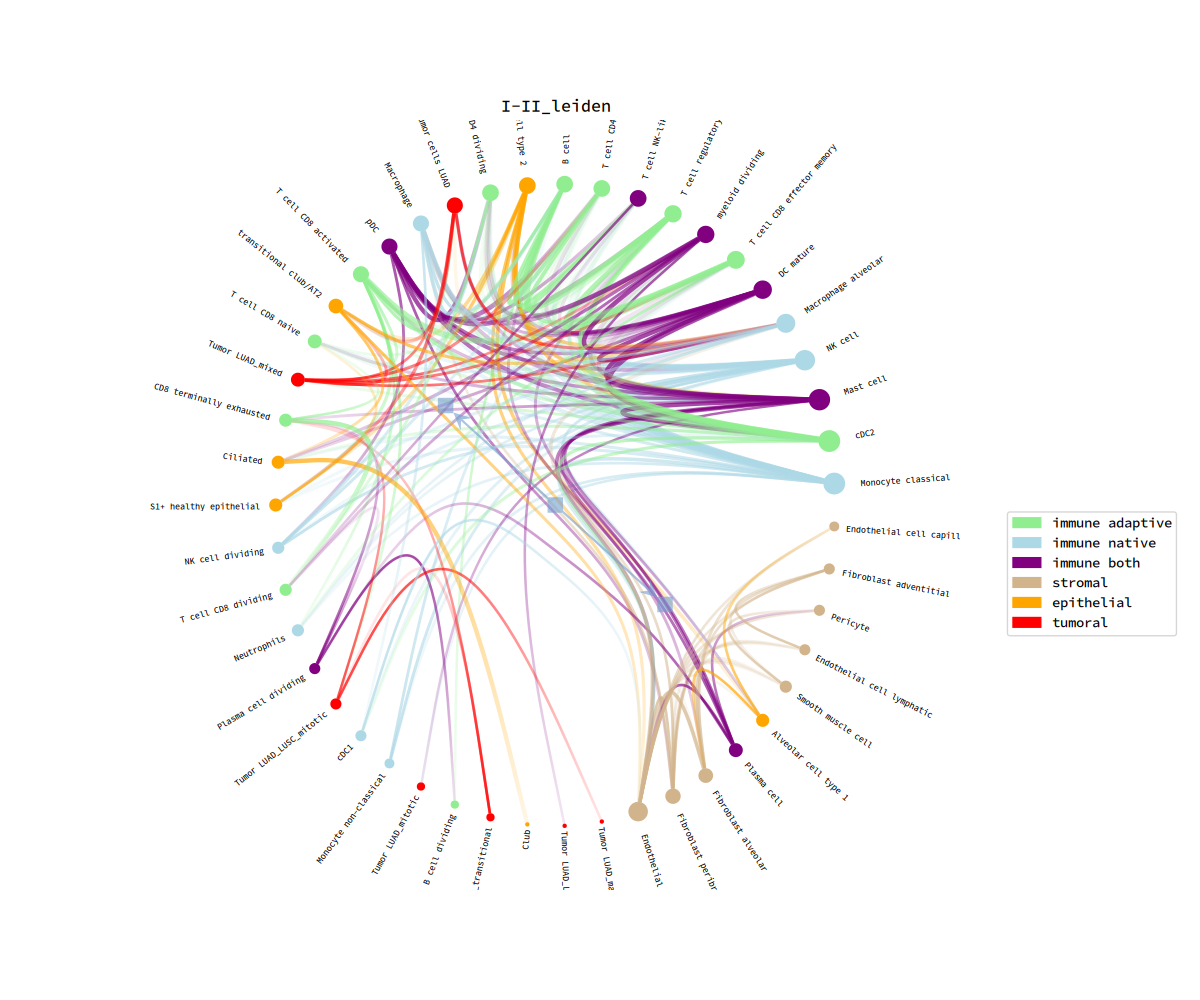

In [129]:
paint_net_from_state(state_early, g_early, "I-II_leiden")

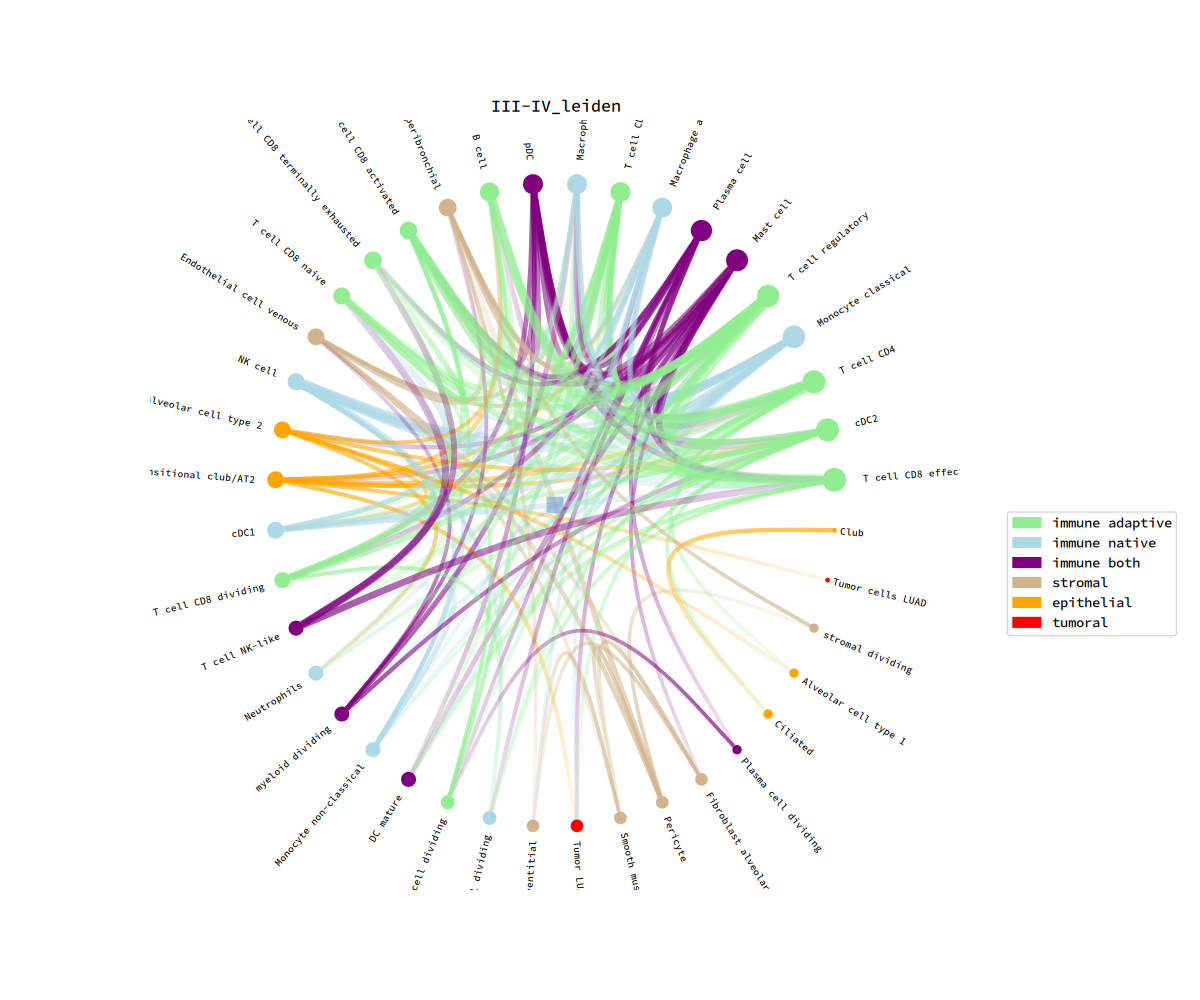

In [159]:
paint_net_from_state(state_late, g_late, "III-IV_leiden", mi_divisor=22)